In [19]:
from stylegan2 import Generator, Encoder
from torch import nn, autograd, optim
import pandas as pd
from tqdm import tqdm
import torch
import cv2
import os
from torchvision import utils

# args.cgan = True
build = {"G": True, "D": False, "E": True, "C": True}
size, n_mlp, channel_multiplier, cgan = 256, 8, 2, True
classifier_nof_classes, embedding_size, latent = 2, 10, 512
g_reg_every, lr, ckpt = 4, 0.002, '../results/000500.pt'
ckpt = '../results/000500.pt'
device = "cuda"

# for multi-gpu setup
distributed = False

In [20]:
# load checkpoints
start_iter = 0
print("load model:", ckpt)
ckpt = torch.load(ckpt, map_location=lambda storage, loc: storage)
# try:
#     ckpt_name = os.path.basename(ckpt)
#     print("GOT HERE: ", ckpt_name)
#     start_iter = int(os.path.splitext(ckpt_name)[0])

# except ValueError:
#     pass

load model: ../results/000500.pt


In [17]:
import numpy as np
from torchvision import transforms
from torchvision import utils
import torch


transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256,256)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True),
        ]
    )

sample = np.zeros((64, 224, 224, 3))
batch = [transform(im).to("cuda") for im in sample]
batch = torch.stack(batch)
batch = batch.mul(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu', torch.float32).numpy()
batch.shape

(64, 256, 256, 3)

In [21]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

In [22]:
# Build Generator
if build["G"]:
    generator = Generator(
        size, latent, n_mlp, channel_multiplier=channel_multiplier,
        conditional_gan=cgan, nof_classes=classifier_nof_classes, embedding_size=embedding_size
    ).to(device)

    g_ema = Generator(
        size,latent, n_mlp, channel_multiplier=channel_multiplier,
        conditional_gan=cgan, nof_classes=classifier_nof_classes, embedding_size=embedding_size
    ).to(device)
    g_ema.eval()
    accumulate(g_ema, generator, 0)

    g_reg_ratio = g_reg_every / (g_reg_every + 1)
    g_optim = optim.Adam(
        generator.parameters(),
        lr=lr * g_reg_ratio,
        betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
    )

    if ckpt:
        generator.load_state_dict(ckpt["g"])
        g_ema.load_state_dict(ckpt["g_ema"])
        g_optim.load_state_dict(ckpt["g_optim"])

    if distributed:
        generator = nn.parallel.DistributedDataParallel(
            generator,
            device_ids=[args.local_rank],
            output_device=args.local_rank,
            broadcast_buffers=False,
        )

In [23]:
encoder_ckpt = '../results/000500.pt' #'../results/Pleural Effusion/plural_048000.pt'
# local_rank = int(os.environ["LOCAL_RANK"])

# Build Encoder
if build["E"]:
    encoder = Encoder(
        size, channel_multiplier=channel_multiplier, output_channels=latent
    ).to(device)
    e_optim = optim.Adam(
        encoder.parameters(),
        lr=lr
    )

    if encoder_ckpt is not None:
        # Encoder ckpt given separately
        print("load encoder model:", encoder_ckpt)
        e_ckpt = torch.load(encoder_ckpt, map_location=lambda storage, loc: storage)
    else:
        # Encoder given as part of general ckpt
        e_ckpt = ckpt

    if e_ckpt is not None and "e" in e_ckpt:
        encoder.load_state_dict(e_ckpt["e"])
        e_optim.load_state_dict(e_ckpt["e_optim"])

    if distributed:
        encoder = nn.parallel.DistributedDataParallel(
            encoder,
            device_ids=[local_rank],
            output_device=local_rank,
            broadcast_buffers=False,
        )

load encoder model: ../results/000500.pt


# Latent Interpolation

In [24]:
def __age__(self, w, step_size = -2, magnitude=1):
        alpha = step_size * magnitude
        v = self.age_coeff.named_steps['linearsvc'].coef_[0].reshape((self.w_shape)) # get coefficients from hyperplane
        v = (torch.from_numpy(v).float()).to(self.device)
        new_w = w + alpha * v
        original, _ = self.generator([w], input_is_latent=True)
        synth, _ = self.generator([new_w], input_is_latent=True)
        # save images
        fig = torch.cat([original, synth], dim=0)
        utils.save_image(fig, "real_samples_age.png", nrow=int(2 ** 2), normalize=True)
        return w + alpha * v
    
def __sex__(self, w, step_size = 1, magnitude=1):
    alpha = step_size * magnitude
    v = self.age_coeff.named_steps['linearsvc'].coef_[0].reshape((self.w_shape)) # get coefficients from hyperplane
    v = (torch.from_numpy(v).float()).to(self.device)
    new_w = w + alpha * v
    original, _ = self.generator([w], input_is_latent=True)
    synth, _ = self.generator([new_w], input_is_latent=True)
    # save images
    fig = torch.cat([original, synth], dim=0)
    utils.save_image(fig, "real_samples_sex.png", nrow=int(2 ** 2), normalize=True)
    return w + alpha * v

#### Generate random samples

In [245]:
n_sample = 16

# generate random sample
sample_z = torch.randn(n_sample, latent, device=device)
sample, _ = g_ema([sample_z])
utils.save_image(sample[0], "../random_samples.png", nrow=int(1 ** 0.5), normalize=True)

#### Generate real samples

In [14]:
from torchvision import transforms

transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256,256)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True),
        ]
    )

../../datasets/rsna/00000013_004.png
(256, 256, 3)


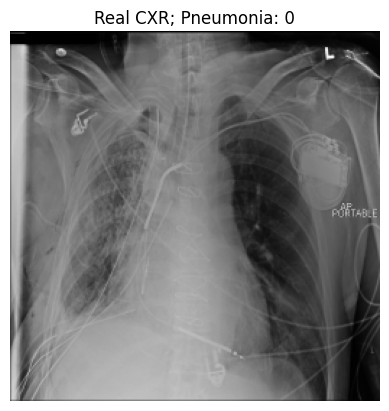

In [62]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

patient_id = 12

# load image
cxpt_csv = pd.DataFrame(pd.read_csv("../../datasets/rsna_patients.csv"))
patient_data = cxpt_csv.iloc[patient_id]
img = cv2.imread("../../datasets/rsna/" + patient_data["Image Index"])
print("../../datasets/rsna/" + patient_data["Image Index"])
# label = 0
# if patient_data["Consolidation"] == 1 or patient_data["Lung Opacity"] == 1 or patient_data["Pneumonia"] == 1:
#     label = 1


plt.imshow(cv2.resize(img, (256,256)));plt.axis(False);plt.title(f"Real CXR; Pneumonia: {0}")

# encode image
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)
encoded = encoder(img)

# reconstruct real-cxr
reconstructed, _ = generator([encoded], input_is_latent=True)

grid = utils.make_grid(reconstructed)
# Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
print(ndarr.shape)
# # save example
# utils.save_image(reconstructed, "../real_samples.png", nrow=int(1 ** 0.5), normalize=True)

#### Train linear SVM: Sex

In [25]:
def load_image(path):
    img = cv2.imread(path)  # Load image using cv2
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)  # Preprocess
    return img_tensor

def process_in_batches(patients, path_prefix, encoder, batch_size):
    style_vectors = []
    for i in tqdm(range(0, len(patients), batch_size)):
        batch_paths = patients.iloc[i : i + batch_size]["Image Index"].tolist()
        batch_imgs = [load_image(path_prefix + path) for path in batch_paths]
        batch_imgs_tensor = torch.cat(batch_imgs, dim=0)  # Stack images in a batch
        with torch.no_grad():  # Avoid tracking gradients to save memory
            # Encode batch to latent vectors in Z space
            w_latents = encoder(batch_imgs_tensor)
        # Move to CPU to save memory and add to list
        style_vectors.extend(w_latents.cpu())
        del batch_imgs_tensor, w_latents # Cleanup and clear cache
        torch.cuda.empty_cache()  # Clear cache to free memory

    return style_vectors

In [26]:
import pandas as pd
n_patients = 500
cxpt_csv = pd.DataFrame(pd.read_csv("../../datasets/rsna_patients.csv"))

# Load 500 latent vectors from each class
male_patients = cxpt_csv[cxpt_csv["Patient Gender"] == "M"][:500]
female_patients = cxpt_csv[cxpt_csv["Patient Gender"] == "F"][:500]
print("Total male patients: ", len(male_patients))
print("Total female patients: ", len(female_patients))

Total male patients:  500
Total female patients:  500


In [27]:
from torchvision import transforms

transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256,256)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True),
        ]
    )

batch_size = 16

# Process male and female images in batches
male_imgs = process_in_batches(male_patients, "../../datasets/rsna/", encoder, batch_size)
female_imgs = process_in_batches(female_patients, "../../datasets/rsna/", encoder, batch_size)
print("male and female embeddings loaded successfully...")

100%|██████████| 32/32 [00:04<00:00,  7.67it/s]

male and female embeddings loaded successfully...


In [29]:
import torch
import random
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# prepare dataset
styles, labels = [], []
styles.extend(male_imgs); labels.extend(list(male_patients["Patient Gender"]))
styles.extend(female_imgs); labels.extend(list(female_patients["Patient Gender"]))

# Convert to NumPy arrays for sklearn compatibility
styles = np.array([style.numpy().flatten() for style in styles])
# styles = torch.stack(styles) 
labels = np.array(labels)


# Shuffle dataset with the same seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Shuffle styles and labels together
indices = np.arange(len(styles))
np.random.shuffle(indices)
styles, labels = styles[indices], labels[indices]

# Split dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(styles, labels, test_size=0.2, random_state=seed)

# Initialize and train linear SVM
# svm_model = SVC(kernel="linear", C=1.0, random_state=seed, tol=1e-5)
# svm_model.fit(X_train, y_train)
clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate model
print("Gender Classification Performance:\n", classification_report(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Gender Classification Performance:
               precision    recall  f1-score   support

           F       0.85      0.93      0.89       100
           M       0.92      0.84      0.88       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200

Accuracy: 88.50%


/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
rate = 0.8
results = [np.random.choice([True, False], p=[rate, 1-rate]) for _ in range(1000)]
print(f"True count: {results.count(True)}, False count: {results.count(False)}")

True count: 811, False count: 189


In [31]:
# fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10
v = clf.named_steps['linearsvc'].coef_[0].reshape((styles[0].shape))
v = (torch.from_numpy(v).float())
type(v)

torch.Tensor

In [41]:
v1, v2 = v.clone(), v.clone()
hyperplanes = torch.cat([v1,v2])
print(v.shape, hyperplanes[:512].shape)
print(v.shape, hyperplanes[512:].shape)

torch.Size([512]) torch.Size([512])
torch.Size([512]) torch.Size([512])


In [131]:
def male2female(w, step_size = 1, is_male=True):
    if is_male:
        step_size = step_size * -1
    alpha, n_images = 0, 4
    
    synth, _ = generator([w], input_is_latent=True)
    interpolations = synth
    for i in range(n_images):
        new_w = w + alpha * v
        synth, _ = generator([new_w], input_is_latent=True)
        interpolations = torch.cat([interpolations, synth], dim=0)
        alpha = alpha + step_size
    # save images
    utils.save_image(interpolations, "../real_samples.png", nrow=int(n_images ** 2), normalize=True)

## Sex-based Interpolation
#### CheXpert image interpolation

In [115]:
import random

interpolations, idx = [], random.randint(0,1000)

# convert all male patients to female
# male_patients = cxpt_csv[cxpt_csv["Sex"] == "Male"]
gender = cxpt_csv.iloc[idx]["Sex"]
age = cxpt_csv.iloc[idx]["Age"]
img = cv2.imread('../../jiezy/1/' + cxpt_csv.iloc[idx]["Path"])
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)
w = encoder(img)

if gender == "Male":
    male2female(w, is_male=True)
else:
    male2female(w, is_male=False)

print(f"Patient Attributes: {gender} {age}")

torch.Size([5, 3, 256, 256])
Patient Attributes: Female 71


#### RSNA image interpolation

In [138]:
import random
import time

interpolations, idx = [], random.randint(0,1000)

rsna_csv = pd.DataFrame(pd.read_csv("../../datasets/rsna_patients.csv"))



# Start timing
start_time = time.time()

img = cv2.imread("../../datasets/augmented_sex/" + rsna_csv.iloc[idx]["Image Index"])

gender = rsna_csv.iloc[idx]["Patient Gender"]
age = rsna_csv.iloc[idx]["Patient Age"]
img = cv2.imread('../../datasets/augmented_sex/' + rsna_csv.iloc[idx]["Image Index"])
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)
w = encoder(img)

if gender == "M":
    male2female(w, is_male=True)
else:
    male2female(w, is_male=False)
    
# Calculate execution time
end_time = time.time()
execution_time = end_time - start_time

print(f"Patient Attributes: {gender} {age}")
print(f"Execution Time: {execution_time:.4f} seconds")

Patient Attributes: M 54
Execution Time: 0.2614 seconds


## Age-based GCA

In [20]:
n_patients = 500
cxpt_csv = pd.DataFrame(pd.read_csv("../../jiezy/1/train.csv"))

# Load 500 latent vectors from each class
young_patients = cxpt_csv[cxpt_csv["Age"] < 20][:500]
old_patients = cxpt_csv[cxpt_csv["Age"] > 80][:500]
print("Total < 20 Y patients: ", len(young_patients))
print("Total 80+ Y patients: ", len(old_patients))

Total < 20 Y patients:  500
Total 80+ Y patients:  500


In [39]:
path = '../../jiezy/1/CheXpert-v1.0-small/train/patient03514/study1/view1_frontal.jpg'
path.split('CheXpert-v1.0-small/')[-1]

'train/patient03514/study1/view1_frontal.jpg'

In [41]:
def load_image(path):
    img = cv2.imread(path)  # Load image using cv2
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_tensor = transform(img).unsqueeze(0).to(device)  # Preprocess
    return img_tensor

def process_in_batches(patients, path_prefix, encoder, batch_size):
    style_vectors = []
    for i in tqdm(range(0, len(patients), batch_size)):
        batch_paths = patients.iloc[i : i + batch_size]["Path"].tolist()
        
        batch_imgs = [load_image(path_prefix + path.split('CheXpert-v1.0-small/')[-1]) for path in batch_paths]

        batch_imgs_tensor = torch.cat(batch_imgs, dim=0)  # Stack images in a batch
        with torch.no_grad():  # Avoid tracking gradients to save memory
            # Encode batch to latent vectors in Z space
            w_latents = encoder(batch_imgs_tensor)
        # Move to CPU to save memory and add to list
        style_vectors.extend(w_latents.cpu())
        del batch_imgs_tensor, w_latents # Cleanup and clear cache
        torch.cuda.empty_cache()  # Clear cache to free memory

    return style_vectors

In [42]:
from torchvision import transforms

transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256,256)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True),
        ]
    )

batch_size = 16

# Process male and female images in batches
young_imgs = process_in_batches(young_patients, "../../jiezy/1/", encoder, batch_size)
old_imgs = process_in_batches(old_patients, "../../jiezy/1/", encoder, batch_size)
print("< 20 Y and 80 Y embeddings loaded successfully...")

100%|██████████| 32/32 [00:48<00:00,  1.26s/it]

< 20 Y and 80 Y embeddings loaded successfully...


In [44]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# prepare dataset
styles, labels = [], []
styles.extend(young_imgs); labels.extend(list(young_patients["Sex"]))
styles.extend(old_imgs); labels.extend(list(old_patients["Sex"]))

# Convert to NumPy arrays for sklearn compatibility
styles = np.array([style.numpy().flatten() for style in styles])
# styles = torch.stack(styles) 
labels = np.array(labels)


# Shuffle dataset with the same seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Shuffle styles and labels together
indices = np.arange(len(styles))
np.random.shuffle(indices)
styles, labels = styles[indices], labels[indices]

# Split dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(styles, labels, test_size=0.2, random_state=seed)

# Initialize and train linear SVM
# svm_model = SVC(kernel="linear", C=1.0, random_state=seed, tol=1e-5)
# svm_model.fit(X_train, y_train)
clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate model
print("Age Classification Performance:\n", classification_report(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Age Classification Performance:
               precision    recall  f1-score   support

      Female       0.84      0.87      0.86        87
        Male       0.90      0.88      0.89       113

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.88      0.88      0.88       200

Accuracy: 87.50%


/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### CheXpert image interpolation

In [83]:
def old2young(w, step_size = -2, is_young=True):
    if is_young:
        step_size = step_size * -1
    alpha, n_images = 0, 4
    
    synth, _ = generator([w], input_is_latent=True)
    interpolations = synth
    for i in range(n_images):
        new_w = w + alpha * v
        synth, _ = generator([new_w], input_is_latent=True)
        interpolations = torch.cat([interpolations, synth], dim=0)
        alpha = alpha + step_size
    # save images
    utils.save_image(interpolations, "../real_samples.png", nrow=int(n_images ** 2), normalize=True)

In [92]:
import random

interpolations, idx = [], random.randint(0,1000)

# convert all male patients to female
# male_patients = cxpt_csv[cxpt_csv["Sex"] == "Male"]
while cxpt_csv.iloc[idx]["Age"] >= 20 and cxpt_csv.iloc[idx]["Age"] <= 80:
    idx = random.randint(0,1000)
gender = cxpt_csv.iloc[idx]["Sex"]
age = cxpt_csv.iloc[idx]["Age"]
img = cv2.imread('../../jiezy/1/' + cxpt_csv.iloc[idx]["Path"])
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)
w = encoder(img)


v = clf.named_steps['linearsvc'].coef_[0].reshape((styles[0].shape))
v = (torch.from_numpy(v).float()).to(device)

if age < 20:
    old2young(w, is_young=True)
elif age > 80:
    old2young(w, is_young=False)

print(f"Patient {idx} Attributes: {gender} {age}")

Patient 373 Attributes: Female 86


In [89]:
interpolations, idx = [], random.randint(0,1000)

idx = 747
gender = cxpt_csv.iloc[idx]["Sex"]
age = cxpt_csv.iloc[idx]["Age"]
img = cv2.imread('../../jiezy/1/' + cxpt_csv.iloc[idx]["Path"])
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)
w = encoder(img)


v = clf.named_steps['linearsvc'].coef_[0].reshape((styles[0].shape))
v = (torch.from_numpy(v).float()).to(device)

if age < 20:
    old2young(w, is_young=True)
elif age > 80:
    old2young(w, is_young=False)

print(f"Patient {idx} Attributes: {gender} {age}")

Patient 747 Attributes: Male 87
